In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import typing
import os
import zipfile
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

In [3]:
from sklearn.metrics import calinski_harabasz_score, silhouette_score, silhouette_samples
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import matplotlib 

In [4]:
#pd.set_option('display.max_rows', None)

In [5]:
root_directory = "your root directory here"
data_directory = "your data directory here"

In [6]:
def ROOT_DIRECTORY():

    global root_directory
    if root_directory == "your root directory here":
        
        root_directory = "."
    return root_directory

def DATA_DIRECTORY():
    
    global data_directory
    if data_directory == "your data directory here":
        
        data_directory = "data/csv_ergast_data"
    
    return data_directory

In [7]:
# LOADING ERGAST DATA
def unzip_data(file_name='f1db_csv.zip', root_directory=ROOT_DIRECTORY(), data_directory=DATA_DIRECTORY()):
    
    path = os.path.join(ROOT_DIRECTORY(), DATA_DIRECTORY(),'f1db_csv.zip')
    with zipfile.ZipFile(path, 'r') as myzip:
        myzip.extractall(os.path.join(ROOT_DIRECTORY(), DATA_DIRECTORY()))

def get_data_from_csv(file_name, root_directory=ROOT_DIRECTORY(), data_directory=DATA_DIRECTORY()):            
    
    csv_data_directory = os.path.join(root_directory, data_directory, file_name)
    return pd.read_csv(csv_data_directory)

In [8]:
results = pd.read_csv('./data/csv_ergast_data/results.csv')
races = pd.read_csv('./data/csv_ergast_data/races.csv')

In [9]:
df = pd.merge(results, races, how="left", on= ["raceId"])
df[df["year"]==2022].raceId.nunique()

22

In [10]:
results

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1
3,4,18,4,4,5,11,4,4,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,1
4,5,18,5,1,23,3,5,5,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25835,25841,1096,854,210,47,12,16,16,16,0.0,57,\N,\N,39,12,1:29.833,211.632,11
25836,25842,1096,825,210,20,16,17,17,17,0.0,57,\N,\N,40,20,1:31.158,208.556,11
25837,25843,1096,1,131,44,5,18,18,18,0.0,55,\N,\N,42,11,1:29.788,211.738,9
25838,25844,1096,849,3,6,20,19,19,19,0.0,55,\N,\N,45,14,1:30.309,210.517,130


In [11]:
unzip_data()

In [12]:
file_names = {"drivers": "drivers.csv", "driver_standings":"driver_standings.csv",
                "circuits": "circuits.csv", 'races': 'races.csv',
                'constructor_results': 'constructor_results.csv', 
                'constructor_standings': 'constructor_standings.csv',
                'constructors': 'constructors.csv', "lap_times": "lap_times.csv", 'pit_stops': 'pit_stops.csv',
                "qualifying": "qualifying.csv", 'results': 'results.csv',
                'seasons': 'seasons.csv', 'status':'status.csv'}


In [13]:
 #855 drivers, 1079 races
results = get_data_from_csv(file_names["results"])
results = results.replace(to_replace = r"\N", value=-1)
results["position"] = pd.to_numeric(results["position"])

In [14]:
driver_identity = get_data_from_csv("drivers.csv")
driver_identity = driver_identity.set_index("driverId")[["forename","surname"]]

In [15]:
def initial_dataset(min_drivers_in_races, max_drivers_in_races, keep_drivers_with_min_total_races = None):

    results = get_data_from_csv(file_names["results"])
    results = results.replace(to_replace = r"\N", value=-1)
    results["position"] = pd.to_numeric(results["position"])
    results = results.set_index('raceId').join(results.groupby('raceId').agg(num_pilots=('position', 'max')))

    results["total_races"] = None #compute total races per driver
    for driver in set(results.driverId.values):
        total_driver_races = len(results[results["driverId"] == driver])
        results.loc[results['driverId'] == driver,"total_races"] = total_driver_races
    
    #results = results[(results.num_pilots>=min_drivers_in_races) & (results.num_pilots<= max_drivers_in_races)]
    
    if keep_drivers_with_min_total_races is not None:
        results = results[results["total_races"] > keep_drivers_with_min_total_races-1]# filtro corredores con minimo de carreras

    results = results[results["position"] != -1]

    return results.reset_index().set_index("driverId")[["raceId", "position",'num_pilots', "total_races"]]

def keep_races_between_drivers_boundaries(df, lower_bound, upper_bound):
    df = df.reset_index()
    df['total_drivers'] = None
    print(f"total races before keep_races_between_drivers_boundaries {lower_bound}, {upper_bound}: {len(set(df.raceId.values))}")

    for race in set(df.raceId.values):
        drivers = df[df["raceId"] == race].position.max()
        # 20 >= 9 >= 150
        if (drivers <= lower_bound) or (drivers >= upper_bound): 
            df = df.drop(df[df["raceId"] == race].index)
        else:
            df.loc[df['raceId'] == race, 'total_drivers'] = drivers

    print(f"total races after keep_races_between_drivers_boundaries {lower_bound}, {upper_bound}: {len(set(df.raceId.values))}")
    return df

def position_counter_dataset_numerical_features(df):
    
    '''@return: how many times a driver got that position?'''

    position_counter = pd.DataFrame(df.groupby("driverId").position.value_counts()) # count positions per driver
    position_counter.rename(columns = {"position": "total_times_in_position"}, inplace=True)
    position_counter = position_counter.sort_values(by=["driverId","position"]).reset_index()
    position_counter = position_counter.set_index("driverId").pivot(columns={"position"}) #pivot in position so every value is now a column
    position_counter.fillna(0, inplace=True)
    position_counter["total_races"] = position_counter.apply(lambda row: row.sum(), axis=1)# add a column with total races per 
    position_counter["[4-6]"] = position_counter.apply(lambda row: row[[("total_times_in_position", n) for n in [_ for _ in range(4, 6 + 1)]]].sum(), axis=1)
    position_counter["[7-10]"] = position_counter.apply(lambda row: row[[("total_times_in_position", n) for n in [_ for _ in range(7, 10 + 1)]]].sum(), axis=1)
    position_counter["[11-15]"] = position_counter.apply(lambda row: row[[("total_times_in_position", n) for n in [_ for _ in range(11, 15 + 1)]]].sum(), axis=1)
    position_counter["[16-25]"] = position_counter.apply(lambda row: row[[("total_times_in_position", n) for n in [_ for _ in range(16, 25 + 1)]]].sum(), axis=1)
    position_counter["[4-10]"]= position_counter.apply(lambda row: row[[("total_times_in_position", n) for n in [_ for _ in range(4, 10 + 1)]]].sum(), axis=1)
    position_counter["[11-25]"] = position_counter.apply(lambda row: row[[("total_times_in_position", n) for n in [_ for _ in range(11, 25 + 1)]]].sum(), axis=1)
    print(f"number of drivers: {len(position_counter)}")

    return position_counter

def position_counter_dataset_categorical(df_dyr):
    
    '''@return: how many times a driver got that position? computing previously the categories per position'''

    dfs = []
    df_dyr.reset_index(inplace=True)
    for race in set(df_dyr.raceId.values):

        df = df_dyr[df_dyr['raceId']== race] #define dataframes per race
        #total_drivers = len(df)
        total_drivers = df['num_pilots'].values[0]
        mask_post_podium = df.position.isin(range(4, 4 + int(((total_drivers - 6)/2)))) #half of the drivers above podium and better than loosers
        mask_second_to_last = df.position.isin(range(4 + int(((total_drivers - 6)/2)),(total_drivers-2)))# better than last
        mask_last = df.position.isin(range((total_drivers-2),(total_drivers+1))) # drivers "loosers" meaning finished in last three positions of a race
        
        df.loc[mask_last, "position"] = "last"
        df.loc[mask_post_podium, "position"] = "post-podium"
        df.loc[mask_second_to_last, "position"] = "second-to-last"
        dfs.append(df)

    result = pd.concat(dfs)

    position_counter = pd.DataFrame(result.groupby("driverId").position.value_counts())
    position_counter.rename(columns = {"position": "total_times_in_position"}, inplace=True)
    position_counter = position_counter.sort_values(by=["driverId","position"]).reset_index()
    position_counter = position_counter.set_index("driverId").pivot(columns={"position"})
    position_counter.fillna(0, inplace=True)
    position_counter["total_races"] = position_counter.apply(lambda row: row.sum(), axis=1)

    return position_counter

def random_sampler_per_driver(df, number_of_races, random_state = 42):
    ''' sample of dataframe to the same number of total races per drivers'''
    df=df.reset_index()
    list_of_dfs = []
    for driver in set(df.driverId.values):
        try:
            list_of_dfs.append(df[df["driverId"]==driver].sample(n = number_of_races, random_state = random_state, replace = False))
        except Exception as e:
            print(f"driverId: {driver}")
            sizer = len(df[df["driverId"]==driver])
            print(f"size df: {sizer}")
            print(f"number of races pass as par: {number_of_races}")
            raise e

    sampled_df= pd.concat(list_of_dfs)

    return df

def prepared_training_data(df, features_list):
    
    '''return ready-to-feed vectors for model training, just keeping the columns of interest from the
    input list `column_names` and in proportion to the number of races per driver'''

    training_df = df[features_list]

    #compute vectors to every driver:
    training_df = training_df.apply(lambda row: row[features_list]/row[features_list].sum(), axis=1)
    
    return training_df

def samples_categorical(features_list, driver_and_races, sampled_number_of_races=30, sampled = False):
    
    '''prepare data for training model where: 
         the position column is converted to categorical data for drivers from 4th to last position,
            and data is vectorized in total times a driver got that position. sample is ready to train a model.'''
    
    if sampled:
        position_counter_sampled = random_sampler_per_driver(driver_and_races,sampled_number_of_races)
        position_counter = position_counter_dataset_categorical(position_counter_sampled)
        training_dataframe = prepared_training_data(position_counter, features_list)

    else:
        position_counter = position_counter_dataset_categorical(driver_and_races)
        training_dataframe = prepared_training_data(position_counter, features_list)

    return training_dataframe, position_counter

def save_as_csv(output):
    pd.output.to_csv(path_or_buf = os.path.join(root_directory, "data/outputs"))

In [16]:
def standarizer(training_dataframe):

    '''standarizes the dataset Standardize features by removing the
    mean and scaling to unit variance'''

    scaler = StandardScaler()
    X_transformed = scaler.fit_transform(training_dataframe)
    
    print(f"scaler mean: {scaler.mean_}")
    print(f"scaler_variance: {scaler.var_}")
    plt.boxplot(X_transformed);
    plt.xticks([1, 2, 3, 4, 5, 6], ['1st', '2nd', '3rd', 'post-podium', 'second-to-last', 'last'], rotation=45)
    plt.title("Boxplots for position counter features  standarized dataset")
    plt.show()
    return pd.DataFrame(X_transformed)

def Kmeans_trainer(training_dataframe, max_clusters):
    
    silhouettes = []
    calinskis = []
    for c in range(2,max_clusters + 1):
        
        miKmeans = KMeans(n_clusters=c, n_init = 600, max_iter = 100000)
        ypred = miKmeans.fit_predict(training_dataframe)
        siluhouette = silhouette_score(training_dataframe, ypred)
        calinski = calinski_harabasz_score(training_dataframe, ypred)
        silhouettes.append(siluhouette)
        calinskis.append(calinski)
        sil_per_sample = silhouette_samples(training_dataframe, ypred)
        
        plt.figure(figsize=(5,5))
        plt.hist(sil_per_sample, label= f"sample_sil_{c}_clusters", alpha=0.5)
        plt.axvline(np.median(np.array(sil_per_sample)), c="red", label="median")
        plt.title(f"Silhouette sample distribution for kmeans with {c} clusters")
        plt.legend()
        plt.show();
        
    print("="*50)
    print(f"total clusters based in silhouette score: {silhouettes.index(max(silhouettes)) + 2}")
    print(f"best silhouette: {max(silhouettes)}")
    print("="*50)
    print(f"total clusters based in calinsky score: {calinskis.index(max(calinskis)) + 2}")
    print(f"best calinsky: {max(calinskis)}")
    
    plt.figure(figsize=(8,8))
    plt.plot([n for n in range(2, max_clusters+1)], calinskis)
    plt.xlabel("number of clusters")
    plt.title("Calinski score per cluster")
    plt.show();
    plt.figure(figsize=(8,8))
    plt.plot([n for n in range(2, max_clusters+1)],silhouettes)
    plt.title("silhouette score per cluster")
    plt.xlabel("number of clusters")
    plt.show();
    
def train_Kmeans_for_selected_cluster(training_dataset, n_clusters, features_list, drivers_names):
    
    '''train model for specific number of clusters
    '''

    scaled_training_dataset = standarizer(training_dataset)
    miKmeans = KMeans(n_clusters=n_clusters, n_init = 600, max_iter = 100000)
    ypred = miKmeans.fit_predict(scaled_training_dataset)
    siluhouette = silhouette_samples(scaled_training_dataset, ypred)
    label_and_score = pd.concat([pd.Series(ypred), pd.Series(siluhouette)], axis=1)
    training_dataset_reseted = training_dataset.reset_index()
    result = training_dataset_reseted.join(label_and_score)
    result.rename(columns = {0: f"label_N_{n_clusters}",1: "sample_silouette"}, inplace = True)
    result.set_index(("driverId",""), inplace=True)
    
    print(f"{miKmeans.inertia_}")
    
    plot_silouette_per_cluster(n_clusters, result)

    result.index.name = "driverId"
    result.sort_values([f"label_N_{n_clusters}",'sample_silouette'], ascending=False)
    print(len(result))
    joined_result = result.join(drivers_names)
    print(len(result))
    return joined_result.sort_values([f"label_N_{n_clusters}",'sample_silouette'], ascending=True)

def plot_silouette_per_cluster(n_cluster, trainig_result):

    cmap = matplotlib.colormaps['gist_rainbow']
    matplotlib.colormaps.get_cmap(cmap)
    
    for n in range(n_cluster):
        
        plt.figure(figsize = (6,6))
        plt.hist(trainig_result[trainig_result[f"label_N_{n_cluster}"] == n]["sample_silouette"], color = cmap(np.random.random()), alpha=0.6, label=f"class {n}");
        plt.legend()
        plt.title("silhouette score per the sample distribution by cluster dataset")
        plt.show()

#gaussian_mixture
def gaussian_mixture_trainer(X,max_clusters):

    silhouettes = []
    calinskis = []
    for c in range(2,max_clusters + 1):
        
        my_gaussian_mixture = GaussianMixture(n_components=c, n_init = 30, max_iter = 800)
        ypred = my_gaussian_mixture.fit_predict(X)
        siluhouette = silhouette_score(X, ypred)
        calinski = calinski_harabasz_score(X, ypred)
        silhouettes.append(siluhouette)
        calinskis.append(calinski)
        print("Silueta",c,": ",siluhouette)
        print("CalinskiHarabasz",c,": ",calinski)
        print("="*50)
        sil_per_sample = silhouette_samples(X, ypred)
        plt.figure(figsize=(5,5))
        plt.hist(sil_per_sample, label= f"sample_sil_{c}_clusters", alpha=0.5)
        plt.axvline(np.median(np.array(sil_per_sample)), c="red", label="silhouettescore median")
        plt.title(f"Sample slhouette score distribution for {c} clusters")
    
        plt.legend()
        plt.show();
        
    print(f"total clusters based in silhouette score: {silhouettes.index(max(silhouettes)) + 2}")
    print("="*50)
    print(f"total clusters based in calinsky score: {calinskis.index(max(calinskis)) + 2}")
    plt.figure(figsize=(5,5))
    plt.plot([n for n in range(2, max_clusters+1)], calinskis)
    plt.show();
    plt.figure(figsize=(5,5))
    plt.plot([n for n in range(2, max_clusters+1)],silhouettes)
    plt.show();

def DBSCAN_trainer(eps_list, X,neighbors_list = [10]):

    silhouettes = []
    eps = eps_list
    clusters = []
    for n in neighbors_list:
        for value in eps:
            my_DBSCAN = DBSCAN(min_samples = n, eps=value)
            y_predict = my_DBSCAN.fit_predict(X)
            siluhouette = silhouette_score(X, y_predict)
    

        # Number of clusters in labels, ignoring noise if present.
            n_clusters = len(set(y_predict)) - (1 if -1 in y_predict else 0)
            clusters.append(n_clusters)
            n_noise = list(my_DBSCAN.labels_).count(-1)
            silhouettes.append((n_clusters, n, eps, siluhouette))

    print(f"Estimated number of clusters: {clusters}")
    print("Estimated number of noise points: %d" % n_noise)

In [17]:
results = get_data_from_csv(file_names["results"])
results = results.replace(to_replace = r"\N", value=-1)
results["position"] = pd.to_numeric(results["position"])
results = results.set_index('raceId').join(results.groupby('raceId').agg(num_pilots=('position', 'max')))

results["total_races"] = None #compute total races per driver
for driver in set(results.driverId.values):
    total_driver_races = len(results[results["driverId"] == driver])
    results.loc[results['driverId'] == driver,"total_races"] = total_driver_races

### Exploratory Data Analysis

In [18]:
results.driverId.nunique()

855

In [19]:
results.columns

Index(['resultId', 'driverId', 'constructorId', 'number', 'grid', 'position',
       'positionText', 'positionOrder', 'points', 'laps', 'time',
       'milliseconds', 'fastestLap', 'rank', 'fastestLapTime',
       'fastestLapSpeed', 'statusId', 'num_pilots', 'total_races'],
      dtype='object')

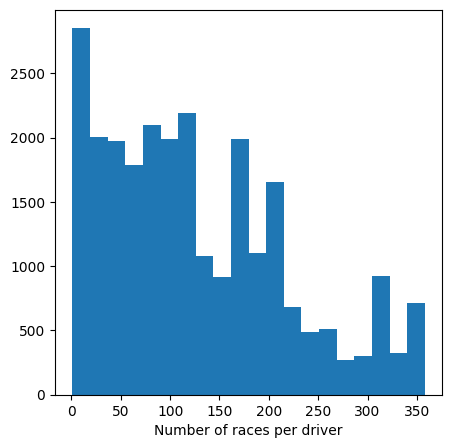

In [20]:
plt.figure(figsize=(5,5))
plt.hist(results["total_races"], bins=20)
plt.xlabel("Number of races per driver")
plt.show()

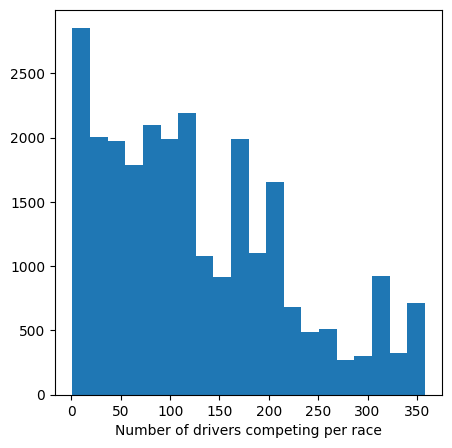

In [22]:
plt.figure(figsize=(5,5))
plt.hist(results["total_races"], bins=20)
plt.xlabel("Number of drivers competing per race")
plt.show()

### Clustering Process

In [22]:
driver_and_races = initial_dataset(min_drivers_in_races = 10, max_drivers_in_races = 150, keep_drivers_with_min_total_races=30)

In [23]:
driver_and_races.head()

,raceId,position,num_pilots,total_races
driverId,,,,
18,1,1,15,309
22,1,2,15,326
15,1,3,15,256
10,1,4,15,95
4,1,5,15,358


In [24]:
df = pd.merge(driver_and_races, races, how="left", on= ["raceId"])
races_2022 = df[df["year"]==2022].raceId.unique()
races_2022

array([1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084,
       1085, 1086, 1087, 1088, 1089, 1091, 1092, 1093, 1094, 1095, 1096])

In [25]:
#keep 2022 apart from the dataset:
print(driver_and_races.shape)
driver_and_races = driver_and_races[~driver_and_races["raceId"].isin(races_2022)]
driver_and_races.shape

(13273, 4)


(12915, 4)

In [26]:
features_cat = [('total_times_in_position', 1),('total_times_in_position', 2),('total_times_in_position', 3),('total_times_in_position', 'post-podium'),
('total_times_in_position', 'second-to-last'),
('total_times_in_position', 'last')]

## Training dataset for drivers having more than 30 races. 

In [27]:
df_training_categorical, position_counter = samples_categorical(features_cat, driver_and_races)

In [28]:
df_training_categorical = df_training_categorical.loc[(df_training_categorical != 0).any(axis=1)]
print(df_training_categorical.shape)

(216, 6)


In [29]:
df_training_categorical.join(driver_identity).head(10)

,"(total_times_in_position, 1)","(total_times_in_position, 2)","(total_times_in_position, 3)","(total_times_in_position, post-podium)","(total_times_in_position, second-to-last)","(total_times_in_position, last)",forename,surname
driverId,,,,,,,,
1,0.391635,0.182510,0.117871,0.247148,0.045627,0.015209,Lewis,Hamilton
2,0.000000,0.057971,0.036232,0.376812,0.355072,0.173913,Nick,Heidfeld
3,0.129944,0.141243,0.050847,0.435028,0.186441,0.056497,Nico,Rosberg
4,0.116788,0.135036,0.105839,0.364964,0.208029,0.069343,Fernando,Alonso
5,0.010989,0.021978,0.010989,0.241758,0.604396,0.109890,Heikki,Kovalainen
6,0.000000,0.000000,0.000000,0.033333,0.633333,0.333333,Kazuki,Nakajima
8,0.073684,0.129825,0.157895,0.354386,0.217544,0.066667,Kimi,Räikkönen
9,0.011765,0.058824,0.070588,0.388235,0.223529,0.247059,Robert,Kubica
10,0.000000,0.027027,0.013514,0.189189,0.378378,0.391892,Timo,Glock


scaler mean: [0.05411169 0.05338321 0.05891112 0.22483448 0.33171874 0.27704076]
scaler_variance: [0.01094694 0.00535659 0.00430912 0.01946756 0.02693388 0.04045541]


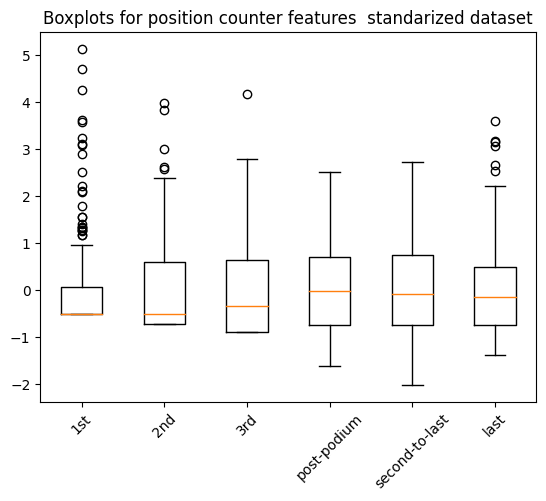

In [30]:
df_training_transformed = standarizer(df_training_categorical)

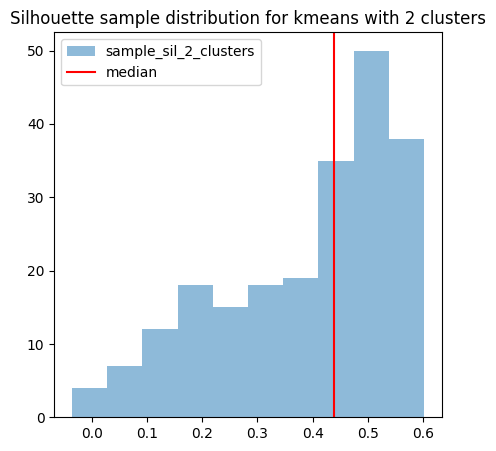

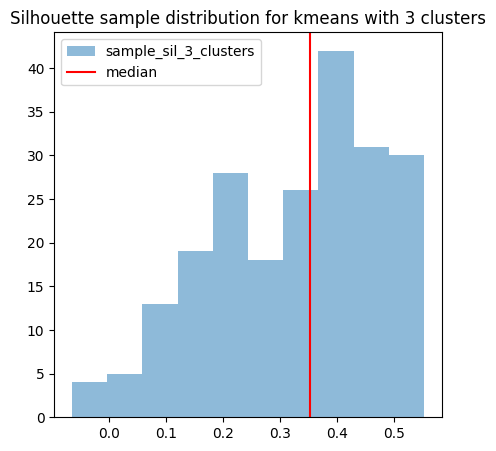

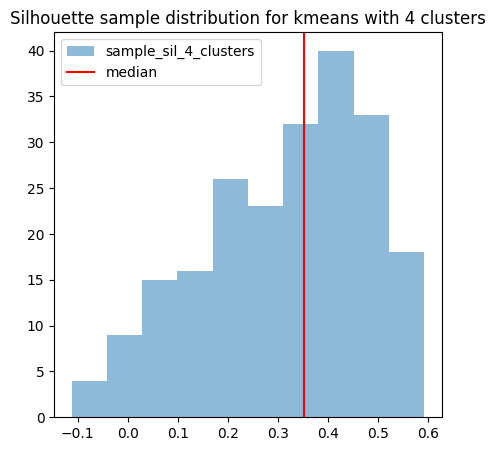

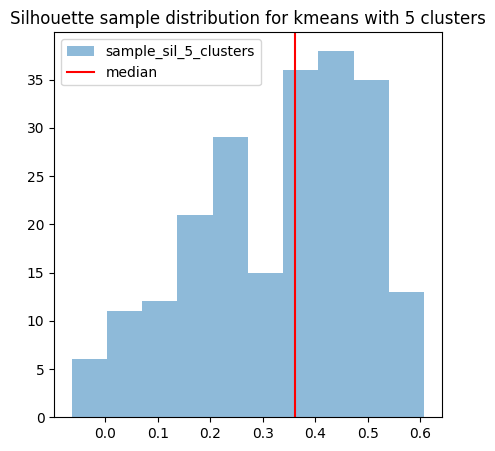

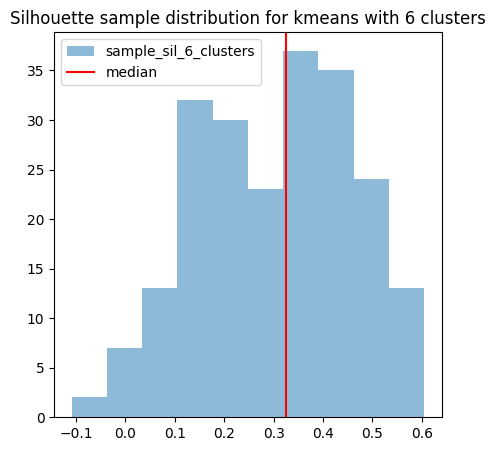

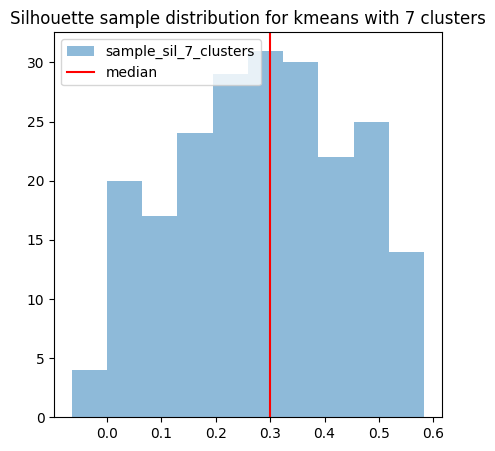

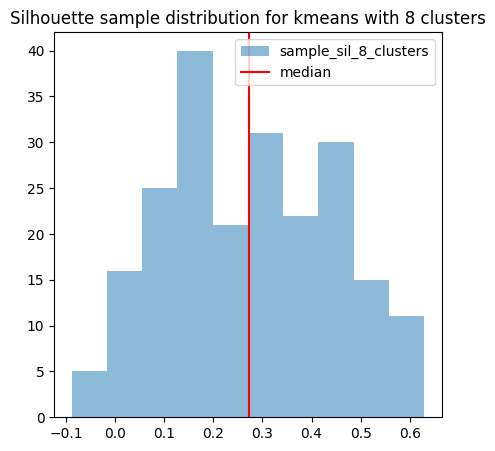

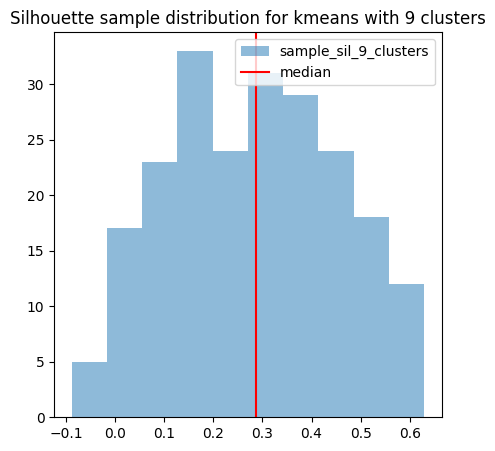

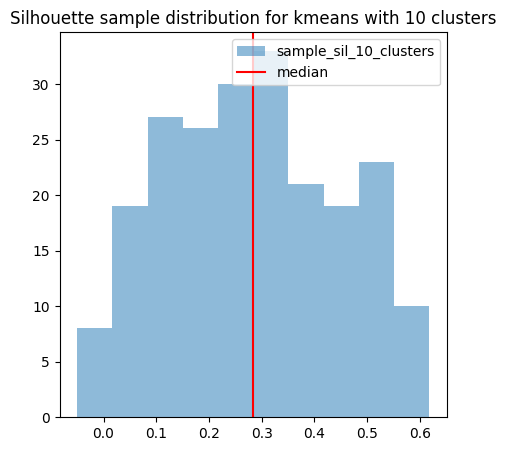

total clusters based in silhouette score: 2
best silhouette: 0.39186160260401803
total clusters based in calinsky score: 2
best calinsky: 154.75226213568592


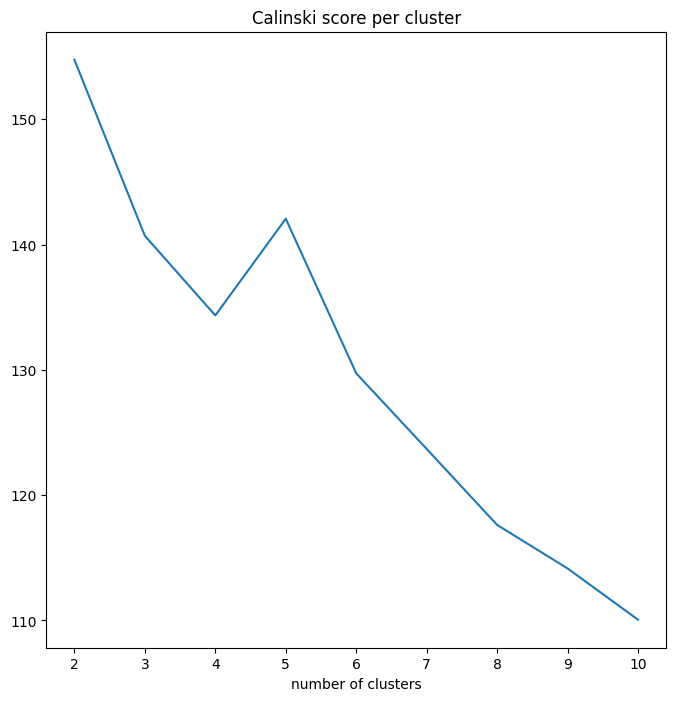

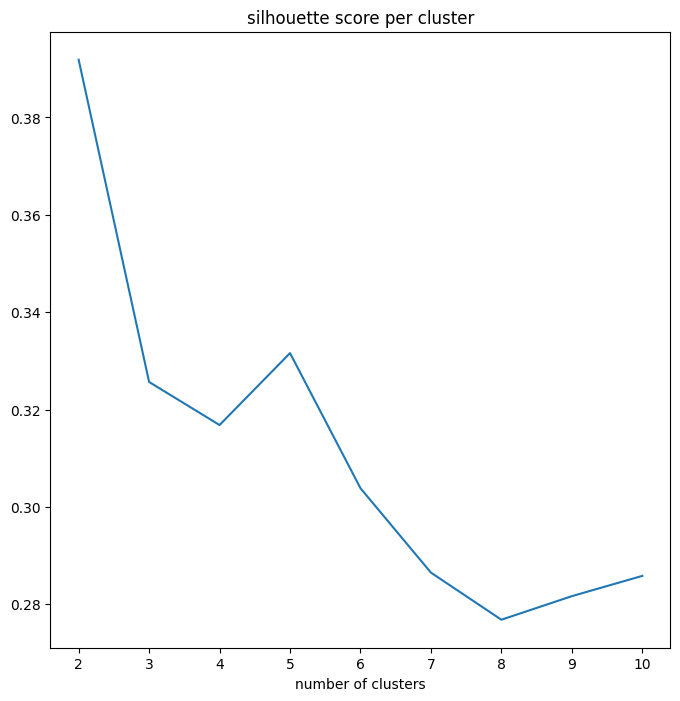

In [31]:
Kmeans_trainer(df_training_transformed, max_clusters=10)

In [32]:
features_cat 

[('total_times_in_position', 1),
 ('total_times_in_position', 2),
 ('total_times_in_position', 3),
 ('total_times_in_position', 'post-podium'),
 ('total_times_in_position', 'second-to-last'),
 ('total_times_in_position', 'last')]

scaler mean: [0.05411169 0.05338321 0.05891112 0.22483448 0.33171874 0.27704076]
scaler_variance: [0.01094694 0.00535659 0.00430912 0.01946756 0.02693388 0.04045541]


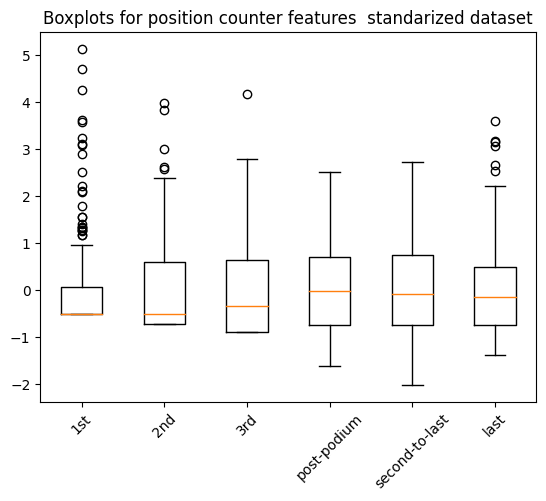

350.9240765859909


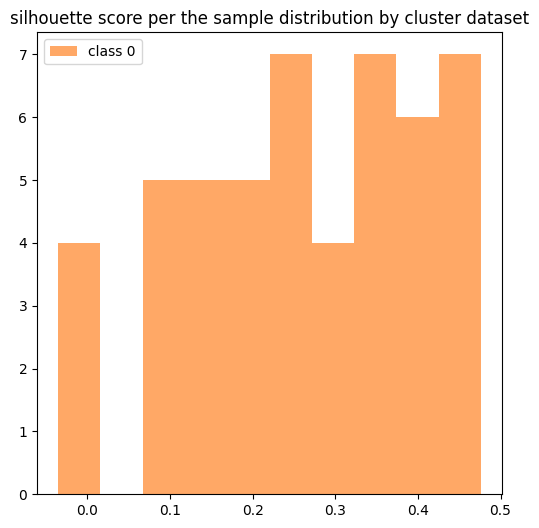

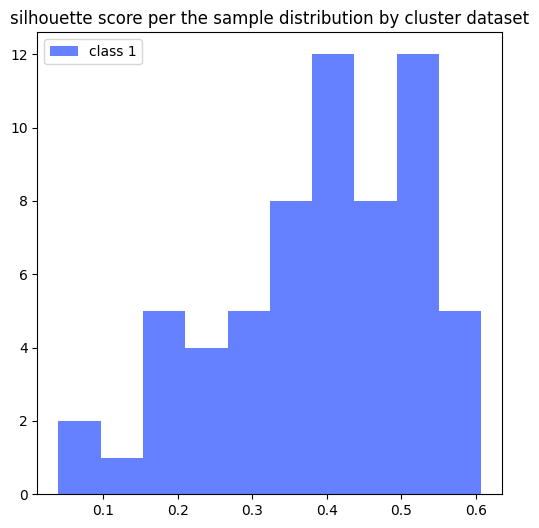

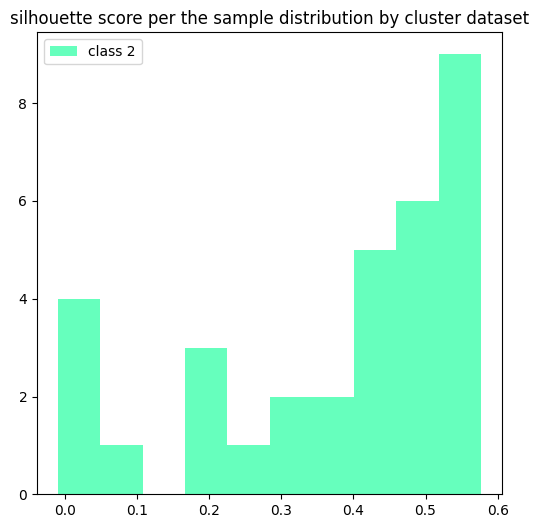

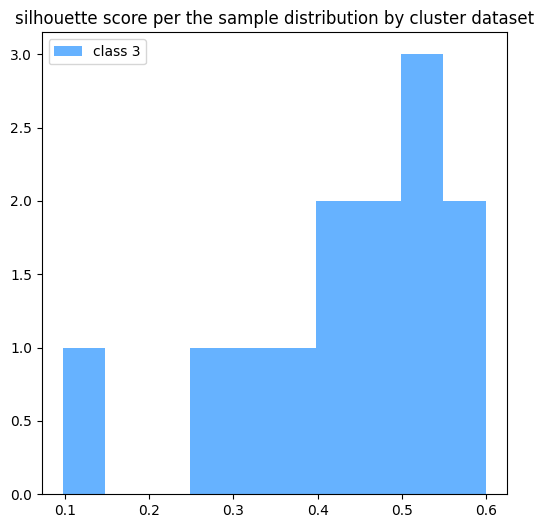

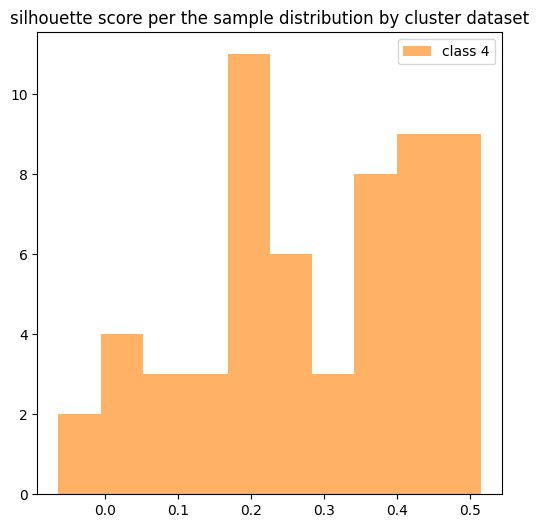

216
216


In [33]:
result_clustering_5 = train_Kmeans_for_selected_cluster(df_training_categorical, 5, features_cat, driver_identity)

In [34]:
result_clustering_5[result_clustering_5['label_N_5']==4]

,"(total_times_in_position, 1)","(total_times_in_position, 2)","(total_times_in_position, 3)","(total_times_in_position, post-podium)","(total_times_in_position, second-to-last)","(total_times_in_position, last)",label_N_5,sample_silouette,forename,surname
driverId,,,,,,,,,,
347,0.020000,0.000000,0.000000,0.280000,0.360000,0.340000,4,-0.063618,Jo,Bonnier
154,0.000000,0.014925,0.059701,0.253731,0.462687,0.208955,4,-0.033741,Romain,Grosjean
206,0.000000,0.000000,0.000000,0.307692,0.384615,0.307692,4,0.007733,Derek,Daly
418,0.000000,0.045455,0.090909,0.181818,0.363636,0.318182,4,0.009632,Masten,Gregory
25,0.000000,0.000000,0.063830,0.276596,0.489362,0.170213,4,0.018405,Alexander,Wurz
212,0.000000,0.000000,0.000000,0.333333,0.466667,0.200000,4,0.023093,Hector,Rebaque
278,0.000000,0.058824,0.156863,0.254902,0.333333,0.196078,4,0.069330,Chris,Amon
230,0.027027,0.000000,0.000000,0.297297,0.297297,0.378378,4,0.082670,Vittorio,Brambilla
427,0.045455,0.068182,0.113636,0.227273,0.272727,0.272727,4,0.105002,Maurice,Trintignant


In [35]:
result_clustering_5[result_clustering_5['label_N_5']==2]

,"(total_times_in_position, 1)","(total_times_in_position, 2)","(total_times_in_position, 3)","(total_times_in_position, post-podium)","(total_times_in_position, second-to-last)","(total_times_in_position, last)",label_N_5,sample_silouette,forename,surname
driverId,,,,,,,,,,
114,0.000000,0.000000,0.000000,0.000000,0.466667,0.533333,2,-0.009141,Yannick,Dalmas
819,0.000000,0.000000,0.000000,0.000000,0.466667,0.533333,2,-0.009141,Charles,Pic
131,0.000000,0.033333,0.033333,0.200000,0.300000,0.433333,2,0.009863,Stefano,Modena
48,0.000000,0.000000,0.000000,0.043478,0.434783,0.521739,2,0.011468,Marc,Gené
346,0.038462,0.038462,0.038462,0.153846,0.288462,0.442308,2,0.102513,Jo,Siffert
37,0.000000,0.017857,0.000000,0.160714,0.321429,0.500000,2,0.178970,Pedro,de la Rosa
314,0.000000,0.000000,0.062500,0.125000,0.312500,0.500000,2,0.180069,Tim,Schenken
219,0.200000,0.000000,0.000000,0.100000,0.200000,0.500000,2,0.218712,Jean-Pierre,Jabouille
92,0.000000,0.000000,0.000000,0.266667,0.200000,0.533333,2,0.237091,Bertrand,Gachot


In [36]:
result_clustering_5[result_clustering_5['label_N_5']==1]

,"(total_times_in_position, 1)","(total_times_in_position, 2)","(total_times_in_position, 3)","(total_times_in_position, post-podium)","(total_times_in_position, second-to-last)","(total_times_in_position, last)",label_N_5,sample_silouette,forename,surname
driverId,,,,,,,,,,
70,0.0,0.000000,0.000000,0.222222,0.333333,0.444444,1,0.040179,Alessandro,Zanardi
75,0.0,0.000000,0.000000,0.055556,0.444444,0.500000,1,0.073015,Shinji,Nakano
90,0.0,0.058824,0.000000,0.235294,0.352941,0.352941,1,0.099789,Roberto,Moreno
196,0.0,0.000000,0.000000,0.000000,0.500000,0.500000,1,0.157431,Raul,Boesel
205,0.0,0.000000,0.000000,0.000000,0.500000,0.500000,1,0.157431,Brian,Henton
...,...,...,...,...,...,...,...,...,...,...
152,0.0,0.000000,0.035714,0.142857,0.535714,0.285714,1,0.554726,Bruno,Giacomelli
64,0.0,0.000000,0.000000,0.128205,0.512821,0.358974,1,0.556570,Pedro,Diniz
838,0.0,0.000000,0.000000,0.088235,0.588235,0.323529,1,0.583020,Stoffel,Vandoorne


In [37]:
result_clustering_5[result_clustering_5['label_N_5']==0]

,"(total_times_in_position, 1)","(total_times_in_position, 2)","(total_times_in_position, 3)","(total_times_in_position, post-podium)","(total_times_in_position, second-to-last)","(total_times_in_position, last)",label_N_5,sample_silouette,forename,surname
driverId,,,,,,,,,,
345,0.068966,0.103448,0.068966,0.310345,0.137931,0.310345,0,-0.035197,Pedro,Rodríguez
17,0.056250,0.100000,0.106250,0.425000,0.231250,0.081250,0,-0.026986,Mark,Webber
163,0.085366,0.109756,0.073171,0.195122,0.280488,0.256098,0,0.009895,René,Arnoux
255,0.071429,0.000000,0.214286,0.214286,0.357143,0.142857,0,0.011208,Gunnar,Nilsson
642,0.185185,0.333333,0.222222,0.222222,0.000000,0.037037,0,0.069049,Nino,Farina
202,0.068182,0.068182,0.159091,0.272727,0.340909,0.090909,0,0.083615,Didier,Pironi
3,0.129944,0.141243,0.050847,0.435028,0.186441,0.056497,0,0.087254,Nico,Rosberg
203,0.153846,0.128205,0.051282,0.282051,0.307692,0.076923,0,0.089144,Gilles,Villeneuve
177,0.084746,0.135593,0.067797,0.372881,0.203390,0.135593,0,0.104194,Keke,Rosberg


In [38]:
drivers = pd.read_csv('./data/csv_ergast_data/drivers.csv')
drivers.set_index("driverId", inplace=True)

In [39]:
pd.merge(result_clustering_5[result_clustering_5['label_N_5']==3], drivers, how="left")

,"(total_times_in_position, 1)","(total_times_in_position, 2)","(total_times_in_position, 3)","(total_times_in_position, post-podium)","(total_times_in_position, second-to-last)","(total_times_in_position, last)",label_N_5,sample_silouette,forename,surname,driverRef,number,code,dob,nationality,url
0,0.272727,0.090909,0.090909,0.136364,0.181818,0.227273,3,0.097749,Tony,Brooks,brooks,\N,\N,1932-02-25,British,http://en.wikipedia.org/wiki/Tony_Brooks
1,0.274725,0.219780,0.098901,0.241758,0.065934,0.098901,3,0.269824,Niki,Lauda,lauda,\N,\N,1949-02-22,Austrian,http://en.wikipedia.org/wiki/Niki_Lauda
2,0.285714,0.194805,0.064935,0.181818,0.103896,0.168831,3,0.335081,Damon,Hill,damon_hill,\N,\N,1960-09-17,British,http://en.wikipedia.org/wiki/Damon_Hill
3,0.500000,0.020000,0.120000,0.120000,0.080000,0.160000,3,0.372262,Jim,Clark,clark,\N,\N,1936-03-04,British,http://en.wikipedia.org/wiki/Jim_Clark
4,0.316327,0.173469,0.112245,0.204082,0.102041,0.091837,3,0.409532,Nigel,Mansell,mansell,\N,\N,1953-08-08,British,http://en.wikipedia.org/wiki/Nigel_Mansell
5,0.356643,0.244755,0.139860,0.146853,0.055944,0.055944,3,0.441450,Alain,Prost,prost,\N,\N,1955-02-24,French,http://en.wikipedia.org/wiki/Alain_Prost
6,0.379630,0.212963,0.148148,0.148148,0.064815,0.046296,3,0.485661,Ayrton,Senna,senna,\N,\N,1960-03-21,Brazilian,http://en.wikipedia.org/wiki/Ayrton_Senna
7,0.590909,0.181818,0.000000,0.227273,0.000000,0.000000,3,0.486822,Alberto,Ascari,ascari,\N,\N,1918-07-13,Italian,http://en.wikipedia.org/wiki/Alberto_Ascari
8,0.545455,0.227273,0.022727,0.136364,0.022727,0.045455,3,0.523633,Juan,Fangio,fangio,\N,\N,1911-06-24,Argentine,http://en.wikipedia.org/wiki/Juan_Manuel_Fangio
9,0.391635,0.182510,0.117871,0.247148,0.045627,0.015209,3,0.530457,Lewis,Hamilton,hamilton,44,HAM,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton


In [40]:
pd.options.display.max_rows = 300

In [41]:
result_clustering_5.columns

Index([               ('total_times_in_position', 1),
                      ('total_times_in_position', 2),
                      ('total_times_in_position', 3),
          ('total_times_in_position', 'post-podium'),
       ('total_times_in_position', 'second-to-last'),
                 ('total_times_in_position', 'last'),
                                         'label_N_5',
                                  'sample_silouette',
                                          'forename',
                                           'surname'],
      dtype='object')

In [42]:
result_clustering_5.to_csv(path_or_buf = os.path.join(root_directory, "data/outputs", "drivers_k_means_5_groups_withouth_2022.csv"))

### Sample Silhouette evaluation

For n_clusters = 2 The average silhouette_score is : 0.39186160260401803
For n_clusters = 3 The average silhouette_score is : 0.3256622697701044
For n_clusters = 4 The average silhouette_score is : 0.31681671995695526
For n_clusters = 5 The average silhouette_score is : 0.3315919519378672
For n_clusters = 6 The average silhouette_score is : 0.3038378885287167
For n_clusters = 7 The average silhouette_score is : 0.28744204846952753


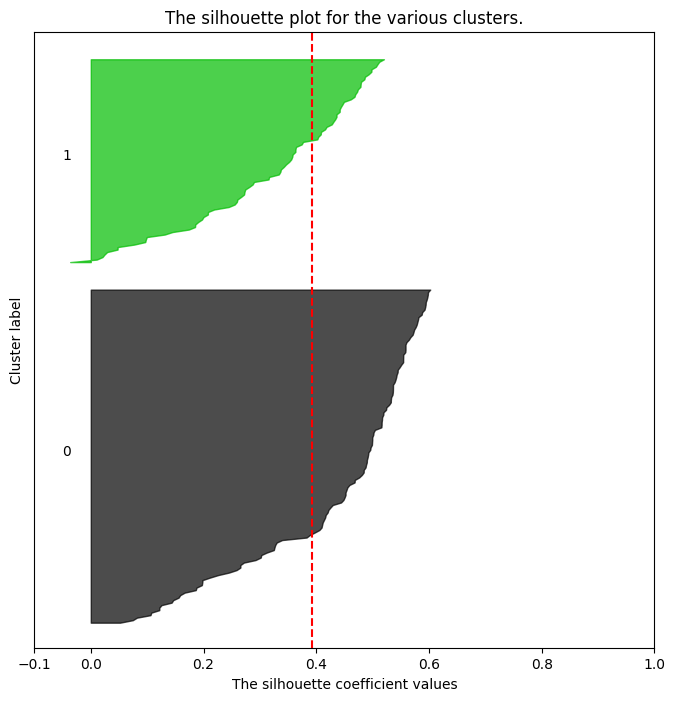

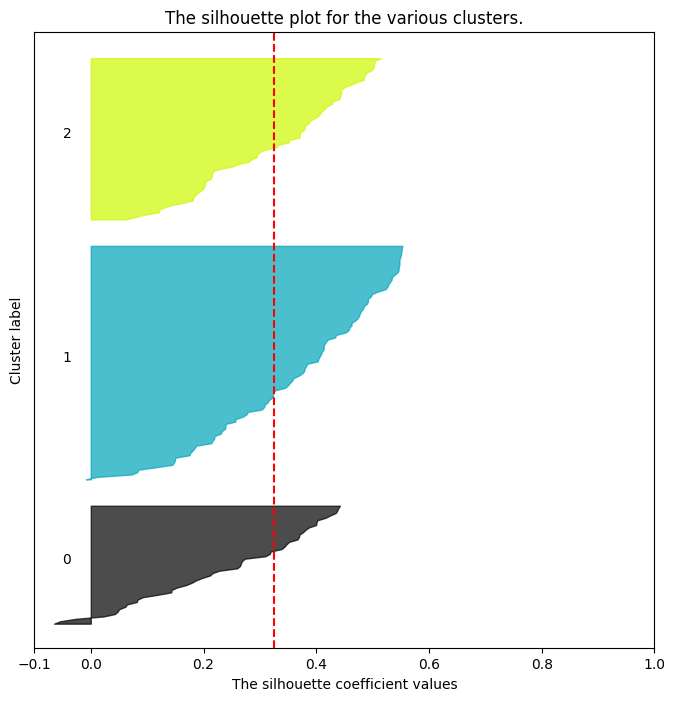

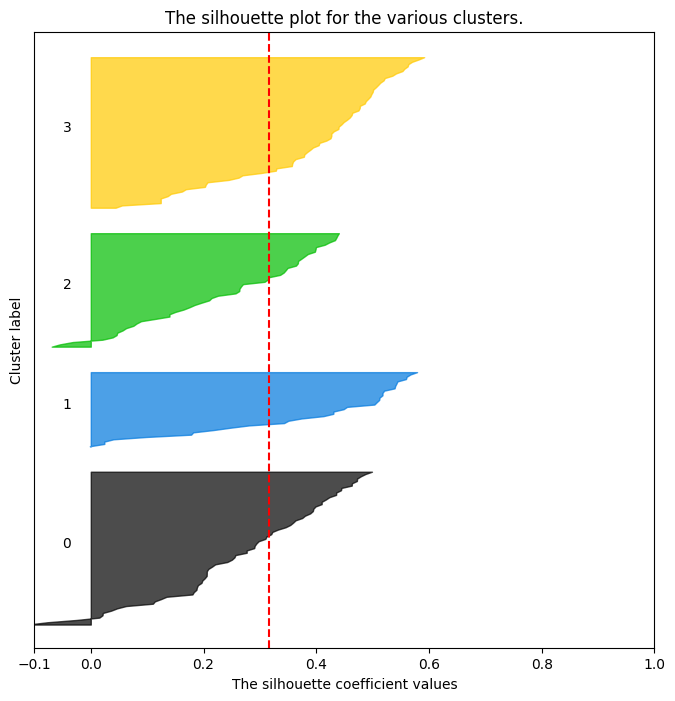

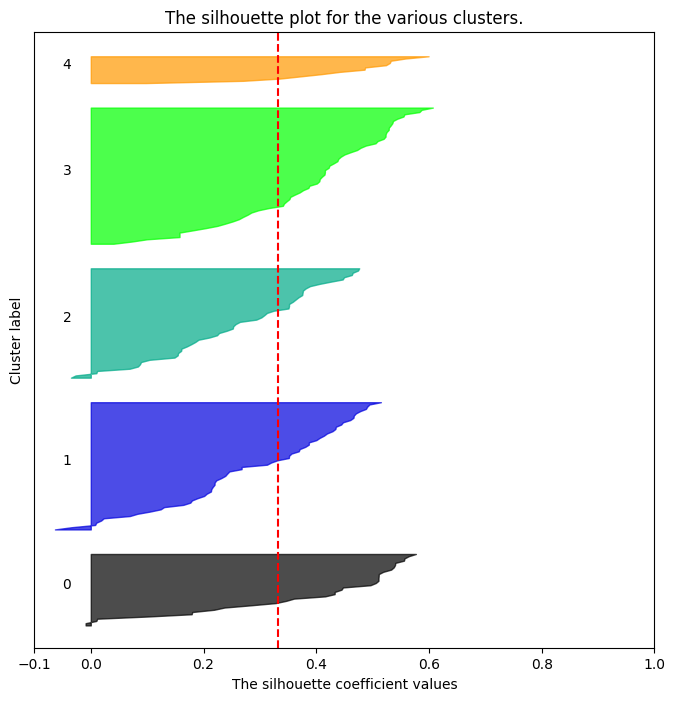

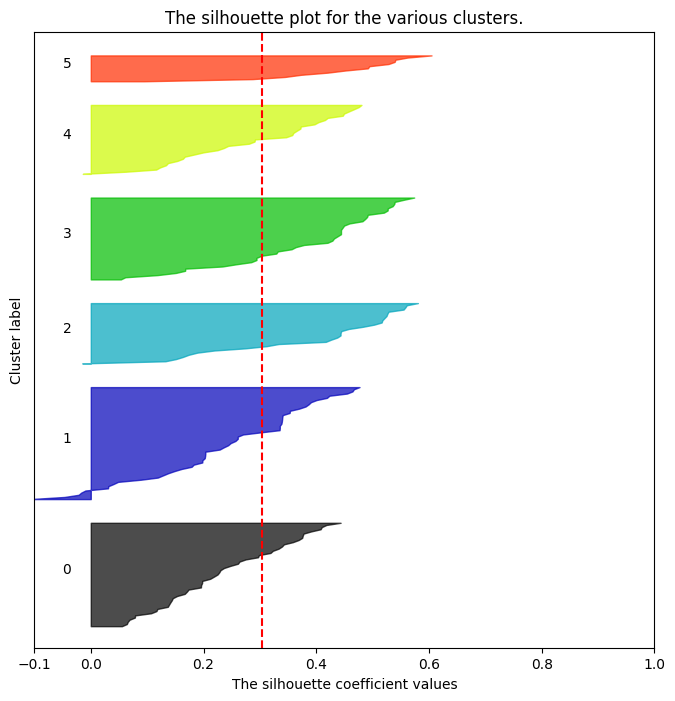

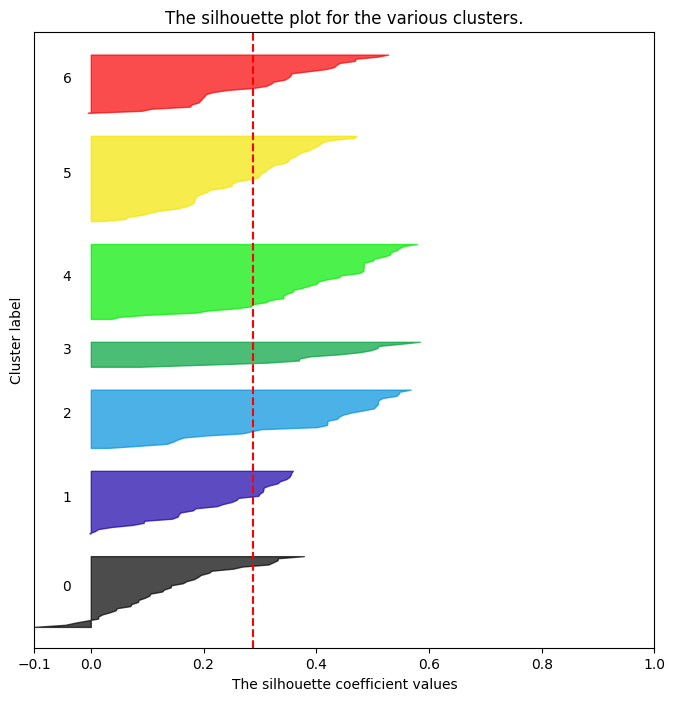

In [53]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

range_n_clusters = [2, 3, 4, 5, 6, 7]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots()
    fig.set_size_inches(8, 8)

    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(df_training_transformed) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value
    
    clusterer = KMeans(n_clusters=n_clusters, n_init = 600, max_iter = 100000)
    cluster_labels = clusterer.fit_predict(df_training_transformed)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters

    silhouette_avg = silhouette_score(df_training_transformed, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_training_transformed, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

Silueta 2 :  0.30787589243120417
CalinskiHarabasz 2 :  114.74468243732503


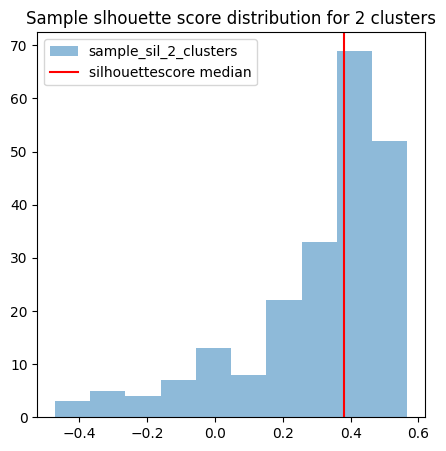

Silueta 3 :  0.17404632710968504
CalinskiHarabasz 3 :  88.39296512671706


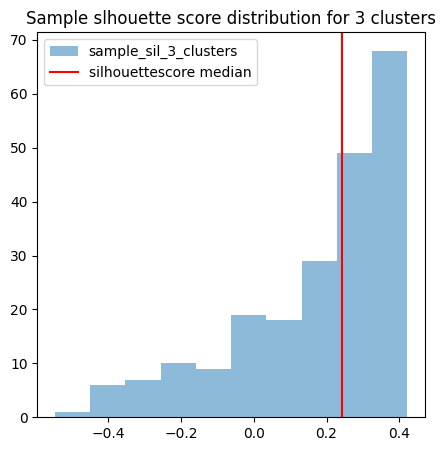

Silueta 4 :  0.10195048968136186
CalinskiHarabasz 4 :  71.30288592965594


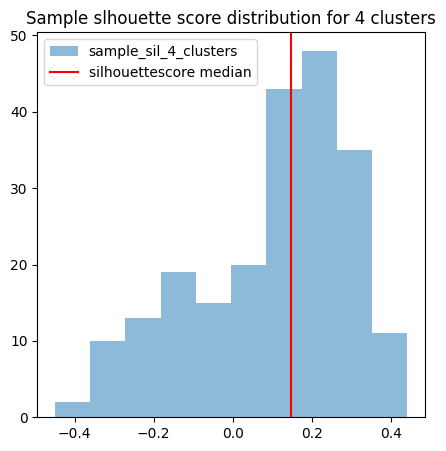

Silueta 5 :  -0.009567329285597129
CalinskiHarabasz 5 :  50.853290084581445


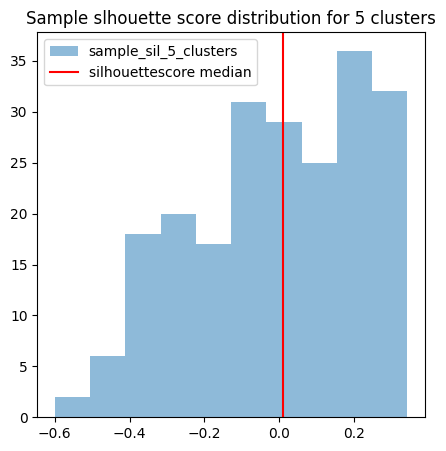

Silueta 6 :  0.07880421223211787
CalinskiHarabasz 6 :  57.984055948115625


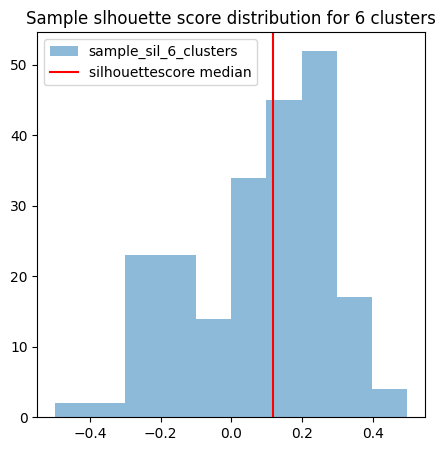

Silueta 7 :  0.06541398193844711
CalinskiHarabasz 7 :  51.21581768684951


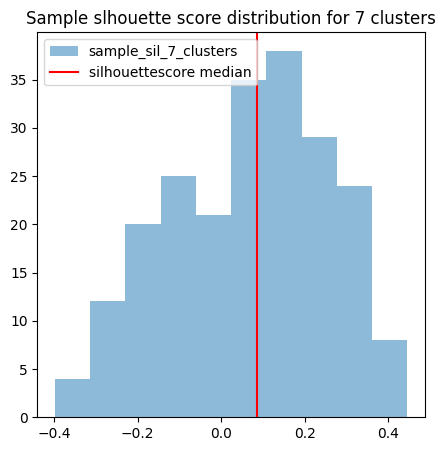

Silueta 8 :  0.02238921815938631
CalinskiHarabasz 8 :  37.62878644104283


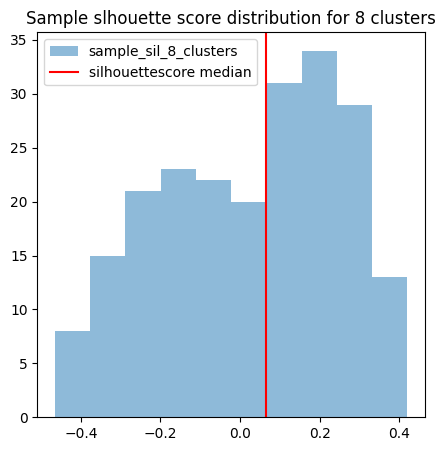

Silueta 9 :  0.047222248676837573
CalinskiHarabasz 9 :  38.94396404370529


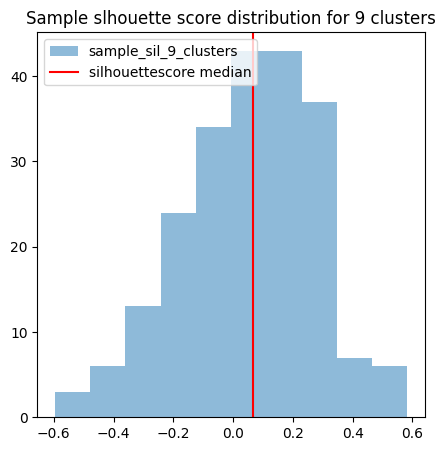

Silueta 10 :  -0.0465844979916183
CalinskiHarabasz 10 :  36.29257814384593


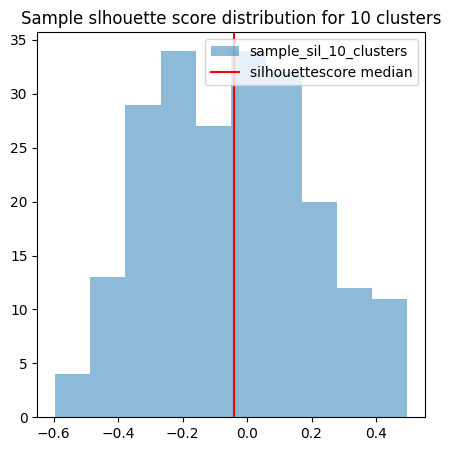

total clusters based in silhouette score: 2
total clusters based in calinsky score: 2


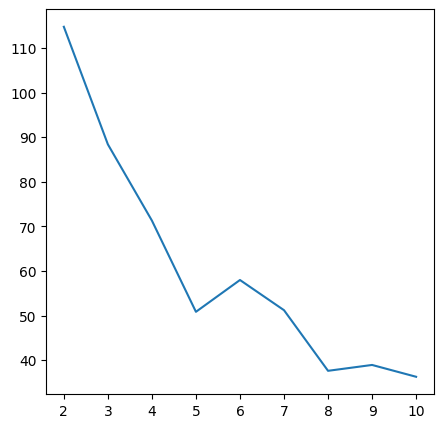

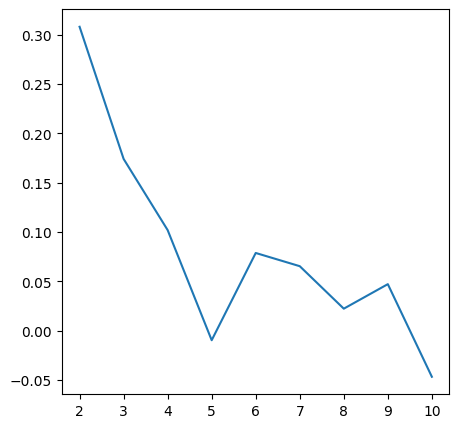

In [54]:
gaussian_mixture_trainer(df_training_transformed,10)

### Hierarchical clustering model

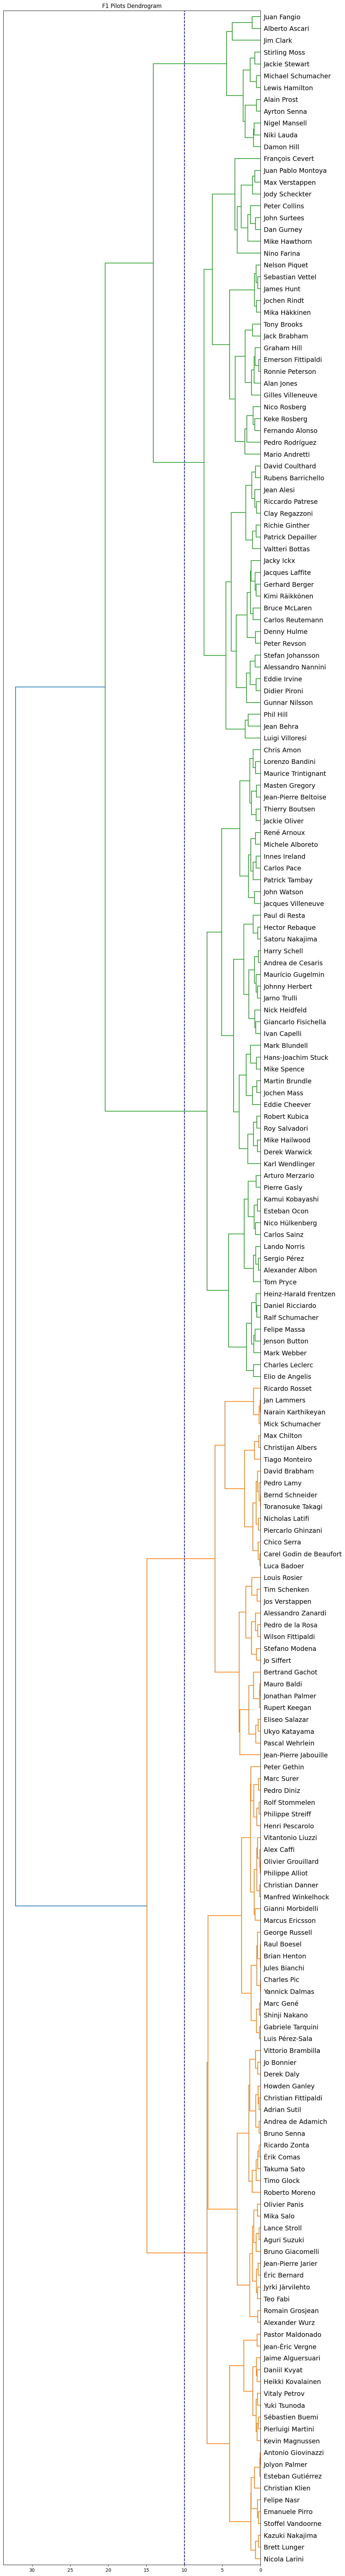

In [142]:
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 100))
plt.title("F1 Pilots Dendrogram")

clusters = shc.linkage(df_training_transformed, 
            method='ward', 
            metric="euclidean", optimal_ordering=True)
#df_training_categorical.shape, clusters.shape, df_training_categorical.join(driver_identity).surname.values.shape

shc.dendrogram(Z=clusters, labels=df_training_categorical.join(driver_identity).forename.values +" "+
                df_training_categorical.join(driver_identity).surname.values, orientation='left', leaf_font_size=14)
plt.axvline(x=10, color='b', linestyle='--')
plt.show()

In [113]:
result_clustering_5

,"(total_times_in_position, 1)","(total_times_in_position, 2)","(total_times_in_position, 3)","(total_times_in_position, post-podium)","(total_times_in_position, second-to-last)","(total_times_in_position, last)",label_N_5,sample_silouette,forename,surname
driverId,,,,,,,,,,
345,0.068966,0.103448,0.068966,0.310345,0.137931,0.310345,0,-0.035197,Pedro,Rodríguez
17,0.056250,0.100000,0.106250,0.425000,0.231250,0.081250,0,-0.026986,Mark,Webber
163,0.085366,0.109756,0.073171,0.195122,0.280488,0.256098,0,0.009895,René,Arnoux
255,0.071429,0.000000,0.214286,0.214286,0.357143,0.142857,0,0.011208,Gunnar,Nilsson
642,0.185185,0.333333,0.222222,0.222222,0.000000,0.037037,0,0.069049,Nino,Farina
202,0.068182,0.068182,0.159091,0.272727,0.340909,0.090909,0,0.083615,Didier,Pironi
3,0.129944,0.141243,0.050847,0.435028,0.186441,0.056497,0,0.087254,Nico,Rosberg
203,0.153846,0.128205,0.051282,0.282051,0.307692,0.076923,0,0.089144,Gilles,Villeneuve
177,0.084746,0.135593,0.067797,0.372881,0.203390,0.135593,0,0.104194,Keke,Rosberg


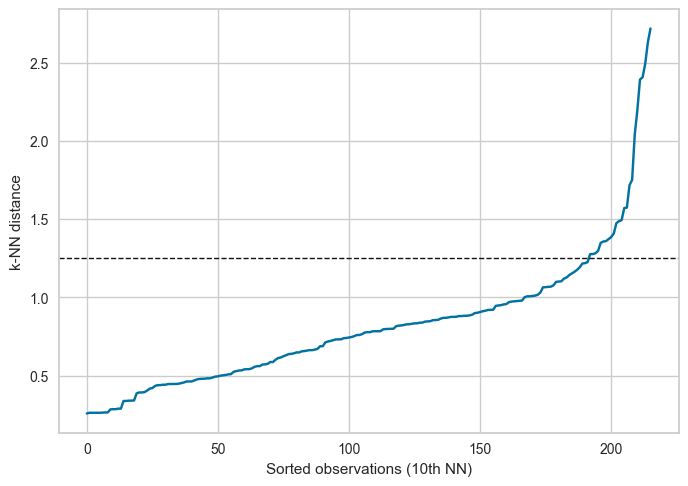

In [73]:
from sklearn.neighbors import NearestNeighbors
# n_neighbors = 5 as kneighbors function returns distance of point to itself (i.e. first column will be zeros) 
nbrs = NearestNeighbors(n_neighbors=6).fit(df_training_transformed)
# Find the k-neighbors of a point
neigh_dist, neigh_ind = nbrs.kneighbors(df_training_transformed)
# sort the neighbor distances (lengths to points) in ascending order
# axis = 0 represents sort along first axis i.e. sort along row
sort_neigh_dist = np.sort(neigh_dist, axis=0)

k_dist = sort_neigh_dist[:, 4]
plt.plot(k_dist)
plt.axhline(y=1.25, linewidth=1, linestyle='dashed', color='k')
plt.ylabel("k-NN distance")
plt.xlabel("Sorted observations (10th NN)")
plt.show()

In [63]:
def DBSCAN_trainer(eps_list, X,neighbors_list = [10]):

    silhouettes = []
    eps = eps_list
    clusters = []
    for n in neighbors_list:
        for value in eps:
            my_DBSCAN = DBSCAN(min_samples = n, eps=value)
            y_predict = my_DBSCAN.fit_predict(X)
            siluhouette = silhouette_score(X, y_predict)
            
            #print("Silueta",value,": ",siluhouette)

        # Number of clusters in labels, ignoring noise if present.
            n_clusters = len(set(y_predict)) - (1 if -1 in y_predict else 0)
            clusters.append(n_clusters)
            n_noise = list(my_DBSCAN.labels_).count(-1)
            silhouettes.append((n_clusters, n, eps, siluhouette))

    print(f"Estimated number of clusters: {clusters}")
    print("Estimated number of noise points: %d" % n_noise)

In [69]:
silhouettes = []
eps_ = [0.25, 0.50, 0.75, 1.0, 1.25, 1.5, 2.0]
eps = [0.3, 0.4, 0.45, 0.5, 0.55, 0.6]
clusters = []
neighbors_list = [6,7,8,9,10,12]
neighbors_list_ = [6]
noises = []
for n in neighbors_list:
    for value in eps:
        my_DBSCAN = DBSCAN(min_samples = n, eps=value)
        y_predict = my_DBSCAN.fit_predict(df_training_transformed)
        #siluhouette = silhouette_score(df_training_transformed, y_predict)
        
        #print("Silueta",value,": ",siluhouette)

    # Number of clusters in labels, ignoring noise if present.
        n_clusters = len(set(y_predict)) - (1 if -1 in y_predict else 0)
        clusters.append(n_clusters)
        n_noise = list(my_DBSCAN.labels_).count(-1)
        noises.append(n_noise)
        #silhouettes.append((n_clusters, n, eps, siluhouette))
        print(f"clusters estimated for n: {n}, eps: {value} is: {n_clusters}")
print(f"Estimated number of clusters: {clusters}")
print(f"Estimated number of noise points: {noises}")


clusters estimated for n: 6, eps: 0.3 is: 1
clusters estimated for n: 6, eps: 0.4 is: 3
clusters estimated for n: 6, eps: 0.45 is: 4
clusters estimated for n: 6, eps: 0.5 is: 5
clusters estimated for n: 6, eps: 0.55 is: 2
clusters estimated for n: 6, eps: 0.6 is: 2
clusters estimated for n: 7, eps: 0.3 is: 0
clusters estimated for n: 7, eps: 0.4 is: 2
clusters estimated for n: 7, eps: 0.45 is: 2
clusters estimated for n: 7, eps: 0.5 is: 5
clusters estimated for n: 7, eps: 0.55 is: 4
clusters estimated for n: 7, eps: 0.6 is: 2
clusters estimated for n: 8, eps: 0.3 is: 0
clusters estimated for n: 8, eps: 0.4 is: 1
clusters estimated for n: 8, eps: 0.45 is: 1
clusters estimated for n: 8, eps: 0.5 is: 5
clusters estimated for n: 8, eps: 0.55 is: 5
clusters estimated for n: 8, eps: 0.6 is: 2
clusters estimated for n: 9, eps: 0.3 is: 0
clusters estimated for n: 9, eps: 0.4 is: 0
clusters estimated for n: 9, eps: 0.45 is: 1
clusters estimated for n: 9, eps: 0.5 is: 1
clusters estimated for n:

In [71]:
from sklearn.cluster import DBSCAN
clusters = DBSCAN(eps=0.45, min_samples=6).fit(df_training_transformed)
# get cluster labels
y = clusters.labels_
set(y)
y
# check unique clusters


array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1,
       -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1,  1, -1,
       -1, -1, -1, -1, -1,  1, -1, -1,  2,  2, -1, -1, -1,  1, -1, -1, -1,
       -1,  2, -1, -1, -1, -1, -1, -1, -1, -1,  1,  0,  2, -1, -1,  0, -1,
       -1, -1,  1,  3, -1, -1, -1, -1, -1, -1,  1, -1,  1, -1, -1, -1, -1,
       -1, -1,  2, -1, -1, -1, -1, -1,  1, -1,  1,  2, -1, -1, -1, -1, -1,
       -1,  1, -1, -1,  1, -1, -1, -1,  2, -1,  3, -1, -1, -1, -1, -1,  3,
        0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1,
        0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1,
       -1, -1, -1, -1,  3, -1, -1, -1,  3, -1, -1,  1, -1, -1, -1, -1, -1,
        1, -1, -1, -1, -1, -1, -1,  3, -1,  2, -1, -1])